# Genetic Algorithms

[Wiki](https://en.wikipedia.org/wiki/Crossover_(genetic_algorithm))

# Packages

In [468]:
#Install required libraries
#install.packages("ggplot2")
#install.packages("tidyr")
#install.packages("tibble")

library(dplyr)
library(ggplot2)
library(tidyr)
library(tibble)

# Parameters

In [602]:
chromosomes <- 50 #Candidate Solutions
genes <- 10 #Variables

number_parents <- 2
number_children <- chromosomes

crossover_probability <- 0.5
mutation_probability <- 0.02
elitism_ratio <- 0.5

# Population

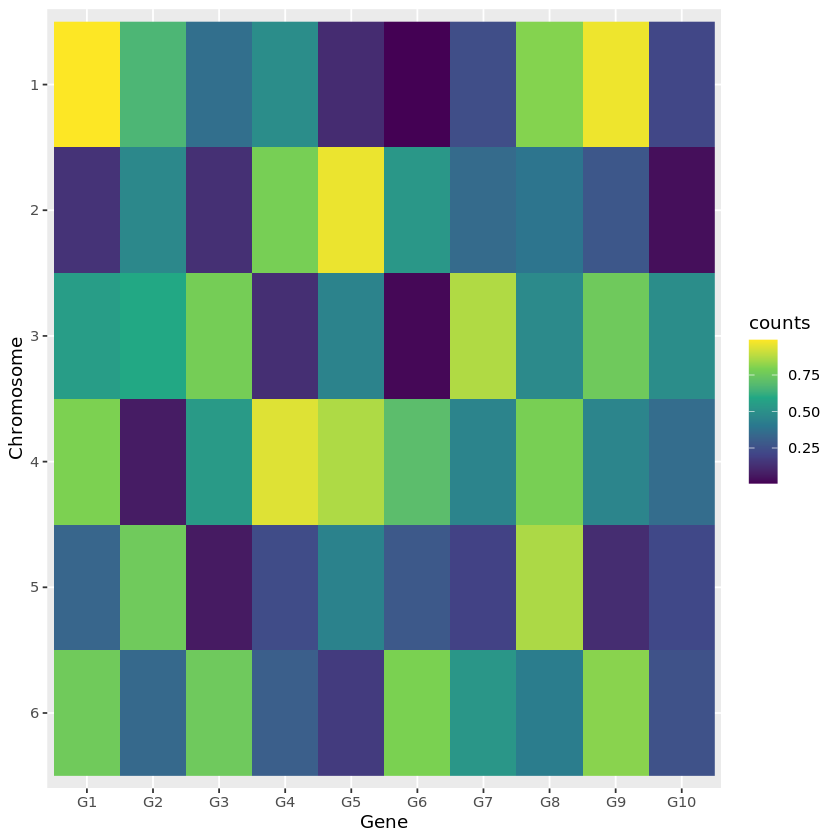

In [603]:
initialize_population <- function(chromosomes, genes) {
    
    #Initialize population with random 0,1 values
    population <- matrix(runif(chromosomes*genes),chromosomes,genes)
    colnames(population) <- paste0("G",seq(1,genes))
    rownames(population) <- paste0(seq(1,chromosomes))

    population_df <- data.frame(population)
    
    return(population_df)
    
}

plot_population <- function(population_df) {
    population_df_plot <- population_df %>%
        head() %>%
        tibble::rownames_to_column("Chromosome") %>%
        tidyr::pivot_longer(-c(Chromosome), names_to = "Gene", values_to = "counts")

    population_df_plot$Chromosome <- factor(population_df_plot$Chromosome, levels=sort(seq(1,chromosomes), decreasing = T))
    population_df_plot$Gene <- factor(population_df_plot$Gene, levels=paste0("G",seq(1,genes)))

    population_df_plot %>%
        #head() %>%
        ggplot(aes(x=Gene, y=Chromosome, fill=counts)) + 
        geom_raster() +
        scale_fill_viridis_c()
}

population_df <- initialize_population(chromosomes, genes)
plot_population(population_df)

# Fitness Function

In [604]:
derive_fitness <- function(genes, population_df) {
    
    #Fitness Function
    fitness_function <- function(genes) {
        value <- genes['G1'] + genes['G2'] + genes['G3'] + genes['G4'] + genes['G5'] + genes['G6'] + genes['G7'] + genes['G8'] + genes['G9'] + genes['G10']
        return(value[[1]])
    }

    #Derive Fitness Score for each gene
    fitness <- c()

    for (i in c(1:chromosomes)) {
        fitness <- c(fitness,fitness_function(population_df[i,]))
    }

    #Fitness Scaling
    if (min(fitness) < 0) {
        fitness_scale <- fitness - min(fitness)
    } else {
        fitness_scale <- fitness
    }

    #Normalise Fitness Scores
    population_df$Fitness <- fitness_scale / sum(fitness_scale)
    population_df$Fitness_Abs <- fitness
    
    return(population_df)
    
}

population_df <- derive_fitness(genes, population_df)
head(population_df)  

,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,Fitness,Fitness_Abs
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.9903563,0.66420699,0.36479584,0.4882046,0.1193300,0.00729706,0.2388524,0.8061963,0.9662380,0.21304516,0.01907946,4.858523
2,0.1443177,0.46651754,0.13396046,0.7826288,0.9597934,0.52992847,0.3502613,0.3907535,0.2756145,0.03373145,0.01597314,4.067507
3,0.5517383,0.59602633,0.77669469,0.1298743,0.4453132,0.02075294,0.8676952,0.4769781,0.7582257,0.48776570,0.02007119,5.111065
4,0.7959948,0.06958433,0.54221614,0.9390440,0.8644348,0.70115850,0.4490066,0.7857142,0.4542836,0.35646986,0.02339675,5.957907
5,0.3302184,0.75934761,0.06407385,0.2349210,0.4407309,0.28191629,0.1963001,0.8620090,0.1227349,0.22004382,0.01379282,3.512296
6,0.7606401,0.34248516,0.75561122,0.3041456,0.1706821,0.79364226,0.5237274,0.4220235,0.8126076,0.25551385,0.02018906,5.141079


# Select Parents

In [605]:
select_parents <- function(number_parents, chromosomes, population_df) {
    
    #Select Chromosomes
    parents <- c()

    while (length(parents) < number_parents) {

        lucky_number <- runif(1)

        #Select chromosome
        lucky_chromosome <- chromosomes + 1 - sum(lucky_number < cumsum(unlist(population_df$Fitness)))
        lucky_chromosome

        #Check, add chromosome to parents, if it is not already chosen
        if (!lucky_chromosome %in% parents) {
            parents <- c(parents,lucky_chromosome)
        }

        length(parents)

    }
    
    return(parents)
}

parents <- select_parents(number_parents, chromosomes, population_df)
parents

[1] 29 32

# Crossover (Recombination)

Local Search, Exploitation

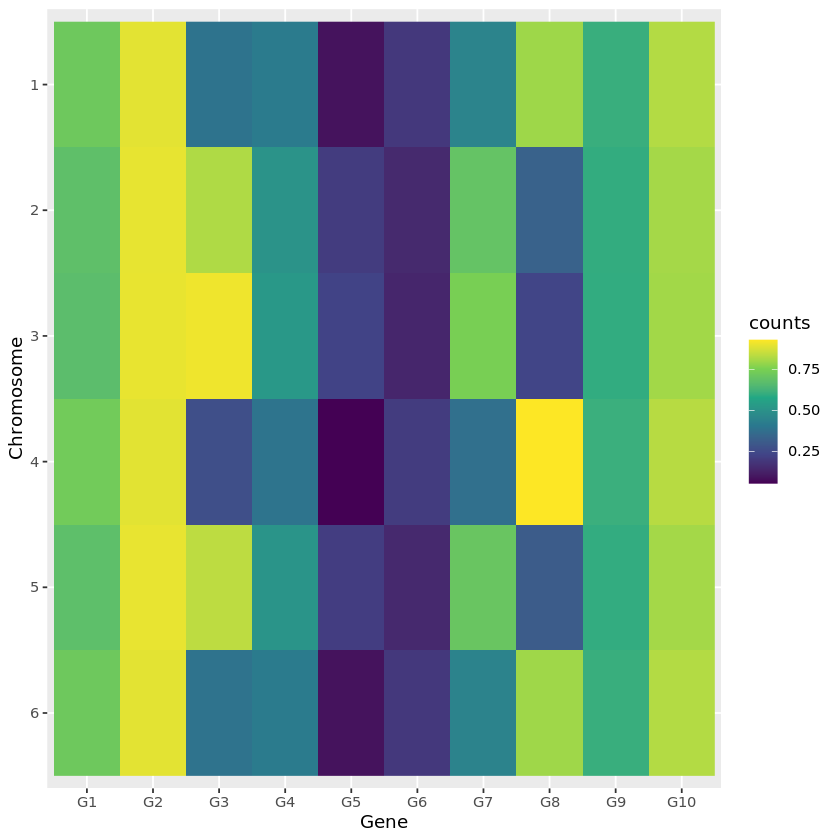

In [660]:
crossover_genes <- function(parents, crossover_probability,number_children, number_parents, population_df) {

    #Create cross-over point
    lower_bound <- 1
    
    #Create empty dataframe
    children <- population_df[1,]
    children <- children[-1,c(1:genes)]
    
    #Get parent genes
    parent_1 <- population_df[parents[1],c(1:genes)]
    parent_2 <- population_df[parents[2],c(1:genes)]
    
    for (i in c(1:number_children)) {
        
        #Mix genes

        beta <- runif(1)
    
        child_1 <- parent_1 * beta + parent_2 * (1 - beta)
        child_2 <- parent_2 * beta + parent_1 * (1 - beta)
         
        #Select parent
        select_parent <- round(runif(1)*(number_parents-1)+1,0)

        if (runif(1) < crossover_probability) {
            select_parent <- round(runif(1) * (number_parents - 1) + 1 , 0)
            children <- rbind(children,population_df[parents[select_parent],c(1:genes)])
        } else {
            if (runif(1) < 0.5) {
                children <- rbind(children,child_1)
            } else {
                children <- rbind(children,child_2)
            }
        }
    }
    
    rownames(children) <- paste0(seq(1,nrow(children)))
    
    return(children)
}

children <- crossover_genes(parents,crossover_probability,number_children, number_parents, population_df)
plot_population(children)

# Mutation

Global search, Exploration

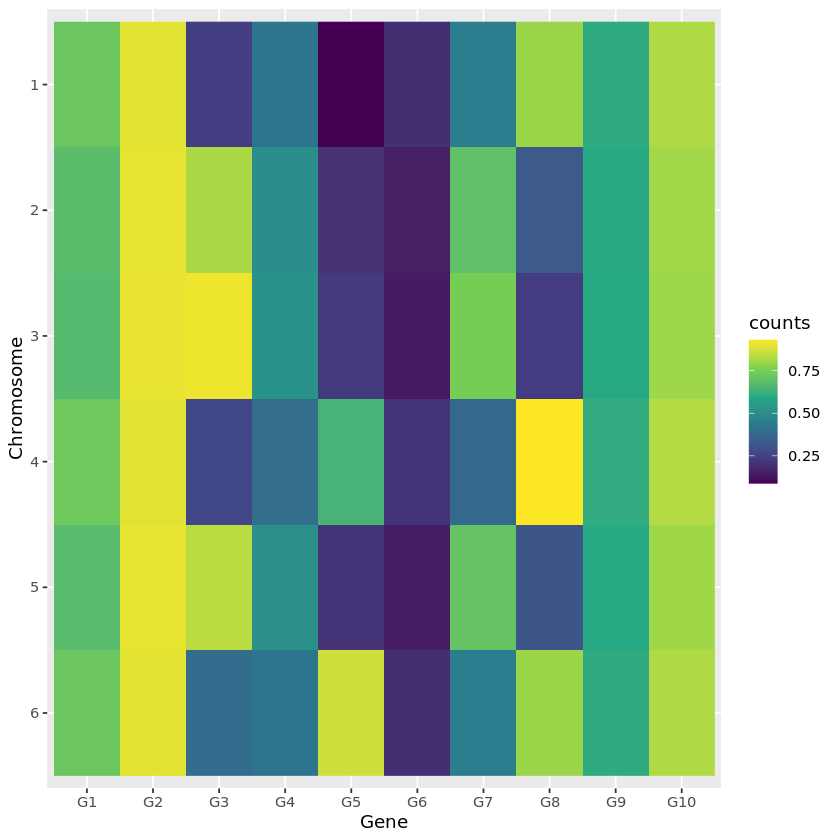

In [666]:
mutate_genes <- function(children, mutation_probability) {
    for (i in c(1:number_children)) {
        for (j in c(1:genes)) {
            mutate <- runif(1) < mutation_probability
            if (mutate) {
                children[i,j] <- runif(1)
            }
        }
    }
    
    return(children)
}

children_mut <- mutate_genes(children,mutation_probability)
plot_population(children_mut)

# Elitism

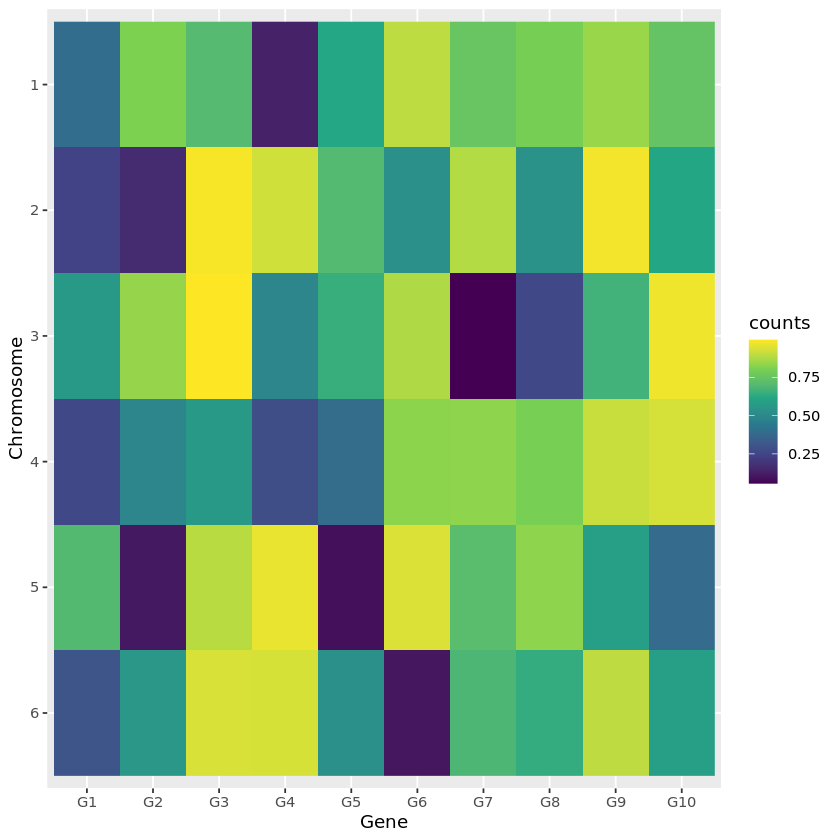

In [667]:
pursue_elites <- function(children_mut, population_df, elitism_ratio, chromosomes) {
    
    no_elites <- round(chromosomes * elitism_ratio, 0)
    
    if (no_elites > 0) {
        elites <- population_df[sort(population_df$Fitness,index.return=TRUE, decreasing=TRUE)$ix[1:no_elites],c(1:genes)]
        
        children_elit <- rbind(elites,children_mut[(no_elites+1):chromosomes,])
    } else {
        children_elit <- children_mut
    }
    
    rownames(children_elit) <- paste0(seq(1,chromosomes))
    
    return(children_elit)
    
}

children_elit <- pursue_elites(children_mut, population_df, elitism_ratio,chromosomes)
plot_population(children_elit)

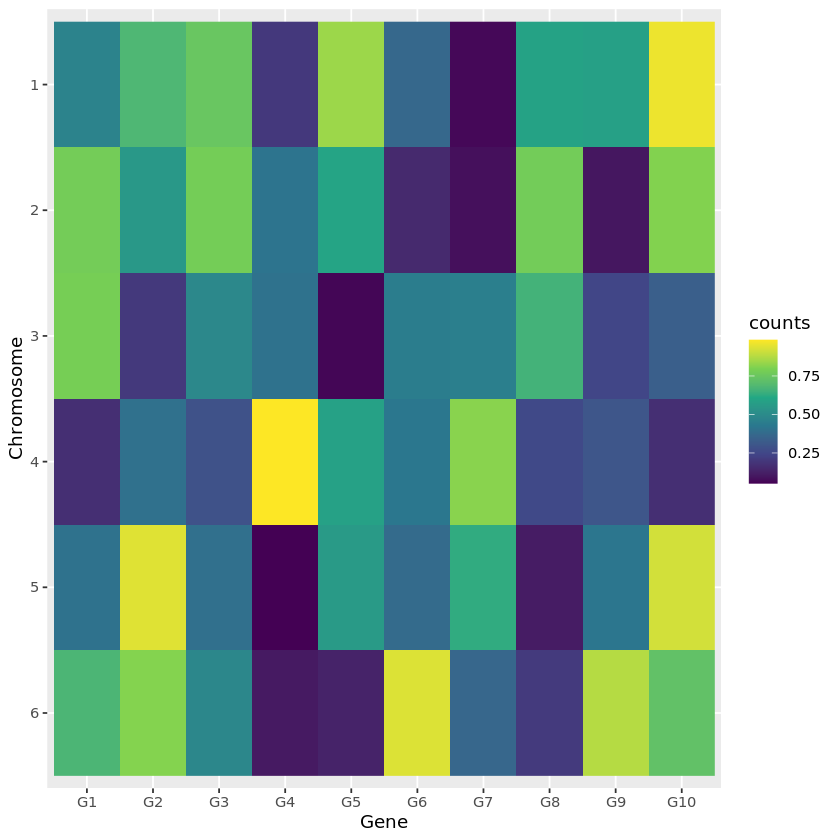

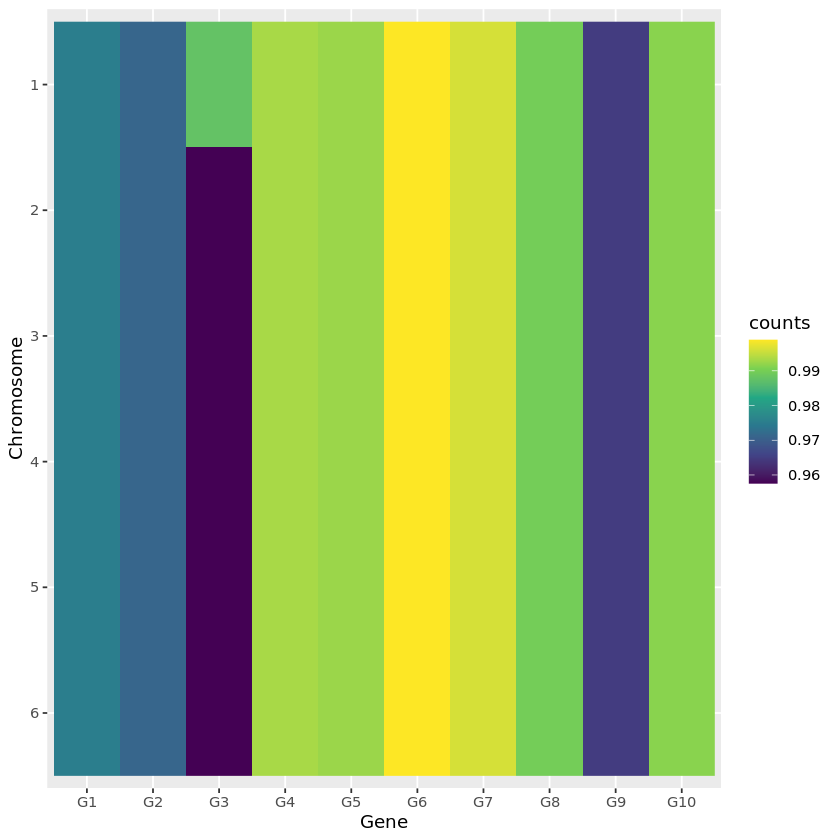

Warning message:
“Removed 1 rows containing missing values (geom_segment).”


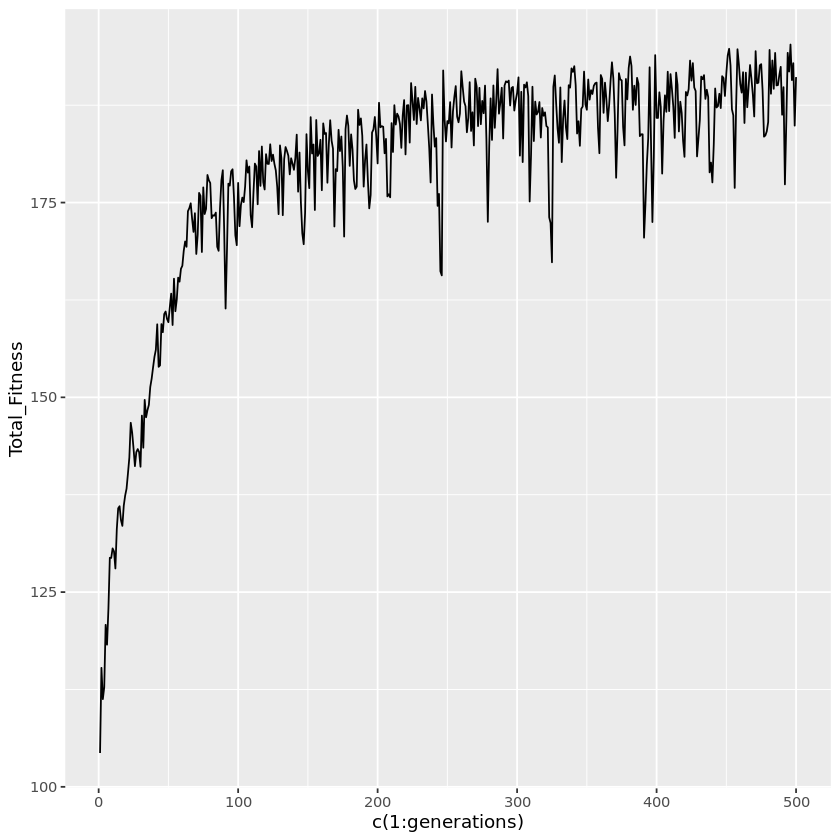

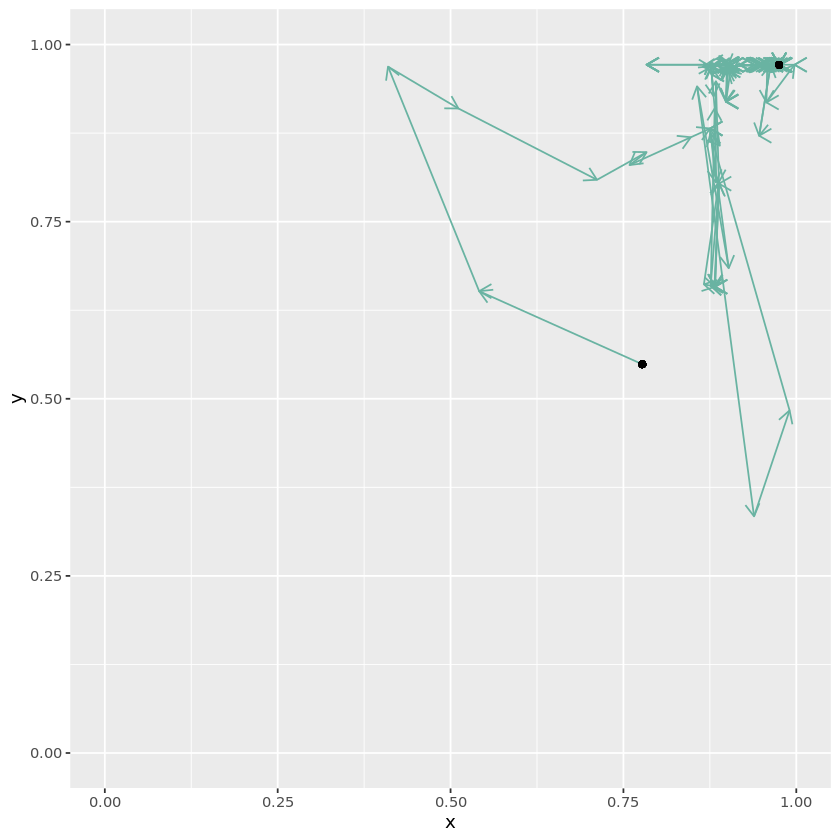

In [710]:
chromosomes <- 20 #Candidate Solutions
genes <- 10 #Variables

number_parents <- 2
number_children <- chromosomes

crossover_probability <- 0.5
mutation_probability <- 0.1
elitism_ratio <- 0.5

population_df <- initialize_population(chromosomes, genes)

plot_population(population_df)

total_fitness <- c()
generations <- 500

history_x <- c()
history_y <- c()

for (i in c(1:generations)) {
    
    population_df <- derive_fitness(genes, population_df)
    
    total_fitness <- c(total_fitness,sum(population_df$Fitness_Abs))

    parents <- select_parents(number_parents, chromosomes, population_df)

    children <- crossover_genes(parents,crossover_probability,number_children, number_parents, population_df)

    children_mut <- mutate_genes(children,mutation_probability)

    children_elit <- pursue_elites(children_mut, population_df, elitism_ratio,chromosomes)

    history_x <- c(history_x,unlist(children_elit$G1[round(chromosomes/2,0)]))
    history_y <- c(history_y,unlist(children_elit$G2[round(chromosomes/2,0)]))
    
    population_df <- children_elit

}

plot_population(population_df)

data.frame('Total_Fitness' = total_fitness) %>%
    ggplot(aes(x=c(1:generations),y=Total_Fitness)) +
    geom_line()

history <- data.frame('x' = history_x, 'y'=history_y)

history %>%
    ggplot(aes(x=x,y=y)) +
    geom_segment(color="#69b3a2", 
      aes(
        xend=c(tail(x, n=-1), NA), 
        yend=c(tail(y, n=-1), NA)
      ),
      arrow=arrow(length=unit(0.3,"cm"))
    ) +
    geom_point(aes(x=x[1],y=y[1])) +
    geom_point(aes(x=x[generations],y=y[generations])) +
    xlim(0, 1) +
    ylim(0, 1)